## Solução placas por superposição.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sympy as smp
import fourierdouble as fd


    A seguinte rotina planeja solucionar o problema análitico de uma placa retangular para qualquer carregamento e condiçãod e contorno, isso é feito em combinação com a rotina Fourierdouble, elaborada anteriormente para a simplificação do carregamento em dupla serie senoidal. È solucionado a partir dessa serie a solução de navier (placa bi engastada) e realizado a superposição das respostas de maneira compatibilizar com as diversas condições de contorno. A partir da função retornavel sol_navier elaborada é possivel obter todos os valores de deslocamentos, tensões rotações, esforços, curvaturas etc.

In [2]:
x,y,a,b,p,wm,v,d,E,f,h,c1,c2,c3,c4, alfa=smp.symbols('x y a b p wm v d E f h c1 c2 c3 c4 alfa')
m,n,i,j=smp.symbols('m n i j', int=True)

In [3]:
E=25000000
v=0.2
h=0.3
d=E*h**3/(12*(1-v**2))
a=10
b=10
alfa=n*x*smp.pi/a
alfa1=smp.pi*n*y/b
d

58593.74999999999

In [4]:
def derivates(W):
    x,y=smp.symbols('x y')
    dwdx=smp.diff(W,x)
    dwdy=(smp.diff(W,y))
    dwdx2=smp.diff((smp.diff(W,x)),x)
    dwdy2=smp.diff((smp.diff(W,y)),y)
    dwdx3=smp.diff(smp.diff((smp.diff(W,x)),x),x)
    dwdy3=smp.diff(smp.diff((smp.diff(W,y)),y),y)
    dwx2y=smp.diff(smp.diff((smp.diff(W,x)),x),y)
    dwxy2=smp.diff(smp.diff((smp.diff(W,x)),y),y)
    mx=(dwdx2+v*dwdy2)*d
    my=(dwdy2+v*dwdx2)*d
    mxy=(1-v)*(smp.diff((smp.diff(W,x)),y))
    vx=-d*(dwdx3+(2-v)*dwxy2)
    vy=-d*(dwdy3+(2-v)*dwx2y)
    dx=-h/2*dwdx2
    dy=-h/2*dwdy2
    gama=-h*(smp.diff((smp.diff(W,x)),y))
    sigmax=E/(1-v)*(dx+v*dy)
    sigmay=E/(1-v)*(v*dx+dy)
    tal=E/2/(1-v)*gama
    
    return dwdx,dwdy,dwdx2, dwdy2, dwdx3, dwdy3,dwdy3,dwx2y,dwxy2,mx,my,mxy,vx,vy,dx,dy,gama,sigmax,sigmay,tal

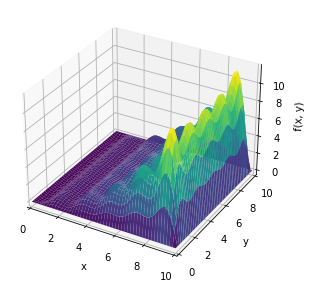

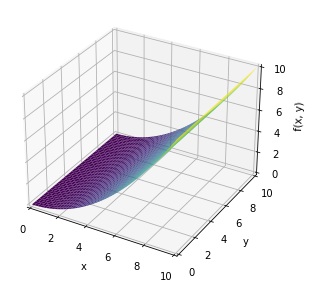

0.901536913130517


In [5]:
k=fd.sfourier_value(10*x**2/a**2 ,10,10,10,10)
fmn=k[0]
fourier=fd.sfourier_doublesin(10*x**2/a**2 ,10,10,10,10)

 A função  definida retorna os valores de deslocamentos W de uma placa , atraves da introdução do carremento obtido pela dupla serie (amplitude do carregamento Fmn, parametros fisicos d, dimensões da placa a e b, e numeros de funções utilizadas na serie de fourier no eixo x(mm) e y (nn). A função por default se nada mais for especificado irá considerar a placa bi-engastada (all_Suport= true), para obtensão das deformadas para outra condição de contorno é necessario especificar qual bordo e qual condição de contorno se deve utilizar, isso é feito atraves dos parametros opcionais, por exemplo se eu quero o bordo direito engastado eu introduziria all_suport= False, Right_fixed= True. para o caso do bordo livre seria right_free=true.

In [6]:
def sol_navier(fmn,d,a,b,mm,nn, all_support=True, left_fixed=False, right_fixed=False,upper_fixed=False,lower_fixed=False, left_free=False,right_free=False,upper_free=False,lower_free=False):
    
    x,y,c1,c2,c3,c4=smp.symbols('x y c1 c2 c3 c4')
    m,n=smp.symbols('m n', int=True)
    
    if all_support:
        wmn=fmn/(d*smp.pi**4*((m**2/a**2)+(n**2/b**2))**2)
        freq=smp.sin(x*smp.pi*m/a)*smp.sin(y*smp.pi*n/b)
        W=smp.summation((smp.summation(wmn*freq,(n,1,nn))),(m,1,mm))
        return W

    if left_fixed:
        wmn=fmn/(d*smp.pi**4*((m**2/a**2)+(n**2/b**2))**2)
        freq=smp.sin(x*smp.pi*m/a)*smp.sin(y*smp.pi*n/b)
        W=smp.summation((smp.summation(wmn*freq,(n,1,nn))),(m,1,mm))
       
        #calculo do giro no apoio esquerdo
        
        dwdx=(smp.diff(W,x))
        theta0=dwdx.subs([(x,0)])
    
        
        #solução exata para momento no bordo esquedo,outra direção apoiada
        
        wh=(c1*smp.cosh(alfa)+c2*alfa*smp.sinh(alfa)+c3*smp.sinh(alfa)+c4*alfa*smp.cosh(alfa))*smp.sin(smp.pi*n*y/b)
        #condições de contorno:
        w0=wh.subs([(x,0)])
        wa=wh.subs([(x,a)])
        
        dwdx2=smp.diff((smp.diff(wh,x)),x)
        dwdy2=smp.diff((smp.diff(wh,y)),y)
        mx=(dwdx2+v*dwdy2)*d
        
        #momemnto no bordo
        
        m0=mx.subs([(x,0)])-smp.sin(smp.pi*y/b)
        ma=mx.subs([(x,a)])
        
        sol=smp.solve([wa,ma,m0,w0],[c1,c2,c3,c4])
        C1=sol[c1]
        C2=sol[c2]
        C3=sol[c3]
        C4=sol[c4]
        Wh=smp.summation((C1*smp.cosh(alfa)+C2*alfa*smp.sinh(alfa)+C3*smp.sinh(alfa)+C4*alfa*smp.cosh(alfa))*smp.sin(smp.pi*n*y/b),(n,1,nn))
        
        #superposição do giro no bordo esquerdo
        
        dwdxh=(smp.diff(Wh,x))
        thetah0=dwdxh.subs([(x,0)])

        
        X=theta0/thetah0
        M2=X*smp.sin(smp.pi*y/b)
        
        #deslocamento final
        
        Wf=Wh*X-W
        
        return Wf
    

    if right_fixed:
        wmn=fmn/(d*smp.pi**4*((m**2/a**2)+(n**2/b**2))**2)
        freq=smp.sin(x*smp.pi*m/a)*smp.sin(y*smp.pi*n/b)
        W=smp.summation((smp.summation(wmn*freq,(n,1,nn))),(m,1,mm))
       
        #calculo do giro no apoio esquerdo
        
        dwdx=(smp.diff(W,x))
        theta0=dwdx.subs([(x,a)])
    
        
        #solução exata para momento no bordo esquedo,outra direção apoiada
        
        wh=(c1*smp.cosh(alfa)+c2*alfa*smp.sinh(alfa)+c3*smp.sinh(alfa)+c4*alfa*smp.cosh(alfa))*smp.sin(smp.pi*n*y/b)
        #condições de contorno:
        w0=wh.subs([(x,0)])
        wa=wh.subs([(x,a)])
        
        dwdx2=smp.diff((smp.diff(wh,x)),x)
        dwdy2=smp.diff((smp.diff(wh,y)),y)
        mx=(dwdx2+v*dwdy2)*d
        
        #momemnto no bordo
        
        m0=mx.subs([(x,0)])
        ma=mx.subs([(x,a)])-smp.sin(smp.pi*y/b)
        
        sol=smp.solve([wa,ma,m0,w0],[c1,c2,c3,c4])
        C1=sol[c1]
        C2=sol[c2]
        C3=sol[c3]
        C4=sol[c4]
        Wh=smp.summation((C1*smp.cosh(alfa)+C2*alfa*smp.sinh(alfa)+C3*smp.sinh(alfa)+C4*alfa*smp.cosh(alfa))*smp.sin(smp.pi*n*y/b),(n,1,nn))
        
        #superposição do giro no bordo esquerdo
        
        dwdxh=(smp.diff(Wh,x))
        thetah0=dwdxh.subs([(x,a)])

        
        X=theta0/thetah0
        M2=X*smp.sin(smp.pi*y/b)
        
        #deslocamento final
        
        Wf=Wh*X-W
        
        return Wf
    
   
    if upper_fixed:
        wmn=fmn/(d*smp.pi**4*((m**2/a**2)+(n**2/b**2))**2)
        freq=smp.sin(x*smp.pi*m/a)*smp.sin(y*smp.pi*n/b)
        W=smp.summation((smp.summation(wmn*freq,(n,1,nn))),(m,1,mm))
       
        #calculo do giro no apoio esquerdo
        
        dwdy=(smp.diff(W,y))
        theta0=dwdy.subs([(y,b)])
    
        
        #solução exata para momento no bordo esquedo,outra direção apoiada
        
        wh=(c1*smp.cosh(alfa1)+c2*alfa1*smp.sinh(alfa1)+c3*smp.sinh(alfa1)+c4*alfa1*smp.cosh(alfa1))*smp.sin(alfa)
        #condições de contorno:
        w0=wh.subs([(y,0)])
        wb=wh.subs([(y,b)])
        
        dwdx2=smp.diff((smp.diff(wh,x)),x)
        dwdy2=smp.diff((smp.diff(wh,y)),y)
        my=(dwdy2+v*dwdx2)*d
        
        #momemnto no bordo
        
        m0=my.subs([(y,0)])
        mb=my.subs([(y,b)])-smp.sin(smp.pi*x/a)
        
        sol=smp.solve([wb,mb,m0,w0],[c1,c2,c3,c4])
        C1=sol[c1]
        C2=sol[c2]
        C3=sol[c3]
        C4=sol[c4]
        Wh=smp.summation((C1*smp.cosh(alfa1)+C2*alfa1*smp.sinh(alfa1)+C3*smp.sinh(alfa1)+C4*alfa1*smp.cosh(alfa1))*smp.sin(alfa),(n,1,nn))
        
        #superposição do giro no bordo esquerdo
        
        dwdyh=(smp.diff(Wh,y))
        thetah0=dwdyh.subs([(y,b)])

        
        X=theta0/thetah0
        M2=X*smp.sin(smp.pi*x/a)
        
        #deslocamento final
        
        Wf=Wh*X-W
        
        return Wf 
    
    if lower_fixed:
        wmn=fmn/(d*smp.pi**4*((m**2/a**2)+(n**2/b**2))**2)
        freq=smp.sin(x*smp.pi*m/a)*smp.sin(y*smp.pi*n/b)
        W=smp.summation((smp.summation(wmn*freq,(n,1,nn))),(m,1,mm))
       
        #calculo do giro no apoio esquerdo
        
        dwdy=(smp.diff(W,y))
        theta0=dwdy.subs([(y,0)])
    
        
        #solução exata para momento no bordo esquedo,outra direção apoiada
        
        wh=(c1*smp.cosh(alfa1)+c2*alfa1*smp.sinh(alfa1)+c3*smp.sinh(alfa1)+c4*alfa1*smp.cosh(alfa1))*smp.sin(alfa)
        #condições de contorno:
        w0=wh.subs([(y,0)])
        wb=wh.subs([(y,b)])
        
        dwdx2=smp.diff((smp.diff(wh,x)),x)
        dwdy2=smp.diff((smp.diff(wh,y)),y)
        my=(dwdy2+v*dwdx2)*d
        
        #momemnto no bordo
        
        m0=my.subs([(y,0)])-smp.sin(smp.pi*x/a)
        mb=my.subs([(y,b)])
        
        sol=smp.solve([wb,mb,m0,w0],[c1,c2,c3,c4])
        C1=sol[c1]
        C2=sol[c2]
        C3=sol[c3]
        C4=sol[c4]
        Wh=smp.summation((C1*smp.cosh(alfa1)+C2*alfa1*smp.sinh(alfa1)+C3*smp.sinh(alfa1)+C4*alfa1*smp.cosh(alfa1))*smp.sin(alfa),(n,1,nn))
        
        #superposição do giro no bordo esquerdo
        
        dwdyh=(smp.diff(Wh,y))
        thetah0=dwdyh.subs([(y,0)])

        
        X=theta0/thetah0
        M2=X*smp.sin(smp.pi*x/a)
        
        #deslocamento final
        
        Wf=Wh*X-W
        
        return Wf    

###########    

    if left_free:
        wmn=fmn/(d*smp.pi**4*((m**2/a**2)+(n**2/b**2))**2)
        freq=smp.sin(x*smp.pi*m/a)*smp.sin(y*smp.pi*n/b)
        W=smp.summation((smp.summation(wmn*freq,(n,1,nn))),(m,1,mm))
       
        #calculo do giro no apoio esquerdo
        
        dwdx3=smp.diff(smp.diff((smp.diff(W,x)),x),x)
        dwdy3=smp.diff(smp.diff((smp.diff(W,y)),y),y)
        dwx2y=smp.diff(smp.diff((smp.diff(W,x)),x),y)
        dwxy2=smp.diff(smp.diff((smp.diff(W,x)),y),y)
        vx=-d*(dwdx3+(2-v)*dwxy2)
        vv0=vx.subs([(x,0)])
        
        #solução exata para momento no bordo esquedo,outra direção apoiada
        
        wh=(c1*smp.cosh(alfa)+c2*alfa*smp.sinh(alfa)+c3*smp.sinh(alfa)+c4*alfa*smp.cosh(alfa))*smp.sin(smp.pi*n*y/b)
        dwdx3h=smp.diff(smp.diff((smp.diff(wh,x)),x),x)
        dwdy3h=smp.diff(smp.diff((smp.diff(wh,y)),y),y)
        dwx2yh=smp.diff(smp.diff((smp.diff(wh,x)),x),y)
        dwxy2h=smp.diff(smp.diff((smp.diff(wh,x)),y),y)
        vx=-d*(dwdx3h+(2-v)*dwxy2h)
        #condições de contorno:
        v0=vx.subs([(x,0)])-smp.sin(smp.pi*y/b)
        wa=wh.subs([(x,a)])
        
        dwdx2=smp.diff((smp.diff(wh,x)),x)
        dwdy2=smp.diff((smp.diff(wh,y)),y)
        mx=(dwdx2+v*dwdy2)*d
        
        #momemnto no bordo
        
        m0=mx.subs([(x,0)])
        ma=mx.subs([(x,a)])
        
        sol=smp.solve([wa,ma,m0,v0],[c1,c2,c3,c4])
        C1=sol[c1]
        C2=sol[c2]
        C3=sol[c3]
        C4=sol[c4]
        Wh=smp.summation((C1*smp.cosh(alfa)+C2*alfa*smp.sinh(alfa)+C3*smp.sinh(alfa)+C4*alfa*smp.cosh(alfa))*smp.sin(smp.pi*n*y/b),(n,1,nn))
        
        #superposição do giro no bordo esquerdo
        
        dwdx3h=smp.diff(smp.diff((smp.diff(Wh,x)),x),x)
        dwdy3h=smp.diff(smp.diff((smp.diff(Wh,y)),y),y)
        dwx2yh=smp.diff(smp.diff((smp.diff(Wh,x)),x),y)
        dwxy2h=smp.diff(smp.diff((smp.diff(Wh,x)),y),y)
        vxh=-d*(dwdx3h+(2-v)*dwxy2h)
        vh0=vxh.subs([(x,0)])

        
        X=vv0/vh0
        M2=X*smp.sin(smp.pi*y/b)
        
        #deslocamento final
        
        Wf=Wh*X-W
        
        return Wf
######   
    if right_free:
        wmn=fmn/(d*smp.pi**4*((m**2/a**2)+(n**2/b**2))**2)
        freq=smp.sin(x*smp.pi*m/a)*smp.sin(y*smp.pi*n/b)
        W=smp.summation((smp.summation(wmn*freq,(n,1,nn))),(m,1,mm))
       
        #calculo do giro no apoio esquerdo
        
        dwdx3=smp.diff(smp.diff((smp.diff(W,x)),x),x)
        dwdy3=smp.diff(smp.diff((smp.diff(W,y)),y),y)
        dwx2y=smp.diff(smp.diff((smp.diff(W,x)),x),y)
        dwxy2=smp.diff(smp.diff((smp.diff(W,x)),y),y)
        vx=-d*(dwdx3+(2-v)*dwxy2)
        vv0=vx.subs([(x,a)])
        
        #solução exata para momento no bordo esquedo,outra direção apoiada
        
        wh=(c1*smp.cosh(alfa)+c2*alfa*smp.sinh(alfa)+c3*smp.sinh(alfa)+c4*alfa*smp.cosh(alfa))*smp.sin(smp.pi*n*y/b)
        dwdx3h=smp.diff(smp.diff((smp.diff(wh,x)),x),x)
        dwdy3h=smp.diff(smp.diff((smp.diff(wh,y)),y),y)
        dwx2yh=smp.diff(smp.diff((smp.diff(wh,x)),x),y)
        dwxy2h=smp.diff(smp.diff((smp.diff(wh,x)),y),y)
        vx=-d*(dwdx3h+(2-v)*dwxy2h)
        #condições de contorno:
        v0=vx.subs([(x,a)])-smp.sin(smp.pi*y/b)
        wa=wh.subs([(x,0)])
        
        dwdx2=smp.diff((smp.diff(wh,x)),x)
        dwdy2=smp.diff((smp.diff(wh,y)),y)
        mx=(dwdx2+v*dwdy2)*d
        
        #momemnto no bordo
        
        m0=mx.subs([(x,0)])
        ma=mx.subs([(x,a)])
        
        sol=smp.solve([wa,ma,m0,v0],[c1,c2,c3,c4])
        C1=sol[c1]
        C2=sol[c2]
        C3=sol[c3]
        C4=sol[c4]
        Wh=smp.summation((C1*smp.cosh(alfa)+C2*alfa*smp.sinh(alfa)+C3*smp.sinh(alfa)+C4*alfa*smp.cosh(alfa))*smp.sin(smp.pi*n*y/b),(n,1,nn))
        
        #superposição do giro no bordo esquerdo
        
        dwdx3h=smp.diff(smp.diff((smp.diff(Wh,x)),x),x)
        dwdy3h=smp.diff(smp.diff((smp.diff(Wh,y)),y),y)
        dwx2yh=smp.diff(smp.diff((smp.diff(Wh,x)),x),y)
        dwxy2h=smp.diff(smp.diff((smp.diff(Wh,x)),y),y)
        vxh=-d*(dwdx3h+(2-v)*dwxy2h)
        vh0=vxh.subs([(x,a)])

        
        X=vv0/vh0
        M2=X*smp.sin(smp.pi*y/b)
        
        #deslocamento final
        
        Wf=Wh*X-W
        
        return Wf
    
#######    
    if upper_free:
        wmn=fmn/(d*smp.pi**4*((m**2/a**2)+(n**2/b**2))**2)
        freq=smp.sin(x*smp.pi*m/a)*smp.sin(y*smp.pi*n/b)
        W=smp.summation((smp.summation(wmn*freq,(n,1,nn))),(m,1,mm))
       
        #calculo do giro no apoio esquerdo
        
        dwdx3=smp.diff(smp.diff((smp.diff(W,x)),x),x)
        dwdy3=smp.diff(smp.diff((smp.diff(W,y)),y),y)
        dwx2y=smp.diff(smp.diff((smp.diff(W,x)),x),y)
        dwxy2=smp.diff(smp.diff((smp.diff(W,x)),y),y)
        vy=-d*(dwdy3+(2-v)*dwx2y)
        vv0=vy.subs([(y,b)])
        
        #solução exata para momento no bordo esquedo,outra direção apoiada
        
        wh=(c1*smp.cosh(alfa1)+c2*alfa1*smp.sinh(alfa1)+c3*smp.sinh(alfa1)+c4*alfa1*smp.cosh(alfa1))*smp.sin(alfa)
        dwdx3h=smp.diff(smp.diff((smp.diff(wh,x)),x),x)
        dwdy3h=smp.diff(smp.diff((smp.diff(wh,y)),y),y)
        dwx2yh=smp.diff(smp.diff((smp.diff(wh,x)),x),y)
        dwxy2h=smp.diff(smp.diff((smp.diff(wh,x)),y),y)
        vx=-d*(dwdy3h+(2-v)*dwx2yh)
        #condições de contorno:
        v0=vx.subs([(y,b)])-smp.sin(smp.pi*x/a)
        wa=wh.subs([(y,0)])
        
        dwdx2=smp.diff((smp.diff(wh,x)),x)
        dwdy2=smp.diff((smp.diff(wh,y)),y)
        my=(dwdy2+v*dwdx2)*d
        
        #momemnto no bordo
        
        m0=my.subs([(y,0)])
        ma=my.subs([(y,b)])
        
        sol=smp.solve([wa,ma,m0,v0],[c1,c2,c3,c4])
        C1=sol[c1]
        C2=sol[c2]
        C3=sol[c3]
        C4=sol[c4]
        Wh=smp.summation((C1*smp.cosh(alfa1)+C2*alfa1*smp.sinh(alfa1)+C3*smp.sinh(alfa1)+C4*alfa1*smp.cosh(alfa1))*smp.sin(alfa),(n,1,nn))
        
        #superposição do giro no bordo esquerdo
        
        dwdx3h=smp.diff(smp.diff((smp.diff(Wh,x)),x),x)
        dwdy3h=smp.diff(smp.diff((smp.diff(Wh,y)),y),y)
        dwx2yh=smp.diff(smp.diff((smp.diff(Wh,x)),x),y)
        dwxy2h=smp.diff(smp.diff((smp.diff(Wh,x)),y),y)
        vxh=-d*(dwdy3h+(2-v)*dwx2yh)
        vh0=vxh.subs([(y,b)])

        
        X=vv0/vh0
        M2=X*smp.sin(smp.pi*x/a)
        
        #deslocamento final
        
        Wf=Wh*X-W
        
        return Wf
###

    if lower_free:
        wmn=fmn/(d*smp.pi**4*((m**2/a**2)+(n**2/b**2))**2)
        freq=smp.sin(x*smp.pi*m/a)*smp.sin(y*smp.pi*n/b)
        W=smp.summation((smp.summation(wmn*freq,(n,1,nn))),(m,1,mm))
       
        #calculo do giro no apoio esquerdo
        
        dwdx3=smp.diff(smp.diff((smp.diff(W,x)),x),x)
        dwdy3=smp.diff(smp.diff((smp.diff(W,y)),y),y)
        dwx2y=smp.diff(smp.diff((smp.diff(W,x)),x),y)
        dwxy2=smp.diff(smp.diff((smp.diff(W,x)),y),y)
        vy=-d*(dwdy3+(2-v)*dwx2y)
        vv0=vy.subs([(y,0)])
        
        #solução exata para momento no bordo esquedo,outra direção apoiada
        
        wh=(c1*smp.cosh(alfa1)+c2*alfa1*smp.sinh(alfa1)+c3*smp.sinh(alfa1)+c4*alfa1*smp.cosh(alfa1))*smp.sin(alfa)
        dwdx3h=smp.diff(smp.diff((smp.diff(wh,x)),x),x)
        dwdy3h=smp.diff(smp.diff((smp.diff(wh,y)),y),y)
        dwx2yh=smp.diff(smp.diff((smp.diff(wh,x)),x),y)
        dwxy2h=smp.diff(smp.diff((smp.diff(wh,x)),y),y)
        vx=-d*(dwdy3h+(2-v)*dwx2yh)
        #condições de contorno:
        v0=vx.subs([(y,0)])-smp.sin(smp.pi*x/a)
        wa=wh.subs([(y,b)])
        
        dwdx2=smp.diff((smp.diff(wh,x)),x)
        dwdy2=smp.diff((smp.diff(wh,y)),y)
        my=(dwdy2+v*dwdx2)*d
        
        #momemnto no bordo
        
        m0=my.subs([(y,0)])
        ma=my.subs([(y,b)])
        
        sol=smp.solve([wa,ma,m0,v0],[c1,c2,c3,c4])
        C1=sol[c1]
        C2=sol[c2]
        C3=sol[c3]
        C4=sol[c4]
        Wh=smp.summation((C1*smp.cosh(alfa1)+C2*alfa1*smp.sinh(alfa1)+C3*smp.sinh(alfa1)+C4*alfa1*smp.cosh(alfa1))*smp.sin(alfa),(n,1,nn))
        
        #superposição do giro no bordo esquerdo
        
        dwdx3h=smp.diff(smp.diff((smp.diff(Wh,x)),x),x)
        dwdy3h=smp.diff(smp.diff((smp.diff(Wh,y)),y),y)
        dwx2yh=smp.diff(smp.diff((smp.diff(Wh,x)),x),y)
        dwxy2h=smp.diff(smp.diff((smp.diff(Wh,x)),y),y)
        vxh=-d*(dwdy3h+(2-v)*dwx2yh)
        vh0=vxh.subs([(y,0)])

        
        X=vv0/vh0
        M2=X*smp.sin(smp.pi*x/a)
        
        #deslocamento final
        
        Wf=Wh*X-W
        
        return Wf
###

    Abaixo chama-se a função com bordo direito engastado, e atraves de uma nova função (lambd_plot) é calculado e retornado todos o valores significativos para o entendimento do problema mecanico da placa (WW,Mx,My,Mxy,Vx,Vy,kx,ky,εx,εy,σx,σy,τxy,tetx,tety) e as plotagens são feitas abaixo, juntamente com a comparação com resultados obtidos por elementos finitos (abaqus).

In [7]:
W_simb=sol_navier(fmn,58593.74999,10,10,8,8,all_support=False,right_fixed=True)
def lambd_plot(W_simb):
    esforços= derivates(W_simb)
    WW=smp.lambdify([x,y],W_simb)
    Mx=smp.lambdify([x,y],esforços[9])
    Mxy=smp.lambdify([x,y],esforços[11])
    My=smp.lambdify([x,y],esforços[10])
    Vx=smp.lambdify([x,y],esforços[12])
    Vy=smp.lambdify([x,y],esforços[13])
    kx=smp.lambdify([x,y],esforços[2])
    ky=smp.lambdify([x,y],esforços[3])
    εx=smp.lambdify([x,y],esforços[14])
    εy=smp.lambdify([x,y],esforços[15])
    γ=smp.lambdify([x,y],esforços[16])
    σx=smp.lambdify([x,y],esforços[17])
    σy=smp.lambdify([x,y],esforços[18])
    τxy=smp.lambdify([x,y],esforços[19])
    tetx=smp.lambdify([x,y],esforços[0])
    tety=smp.lambdify([x,y],esforços[1])
    
    return WW,Mx,My,Mxy,Vx,Vy,kx,ky,εx,εy,σx,σy,τxy,tetx,tety

dissec=lambd_plot(W_simb)

In [8]:
cu=smp.lambdify([x,y],W_simb)

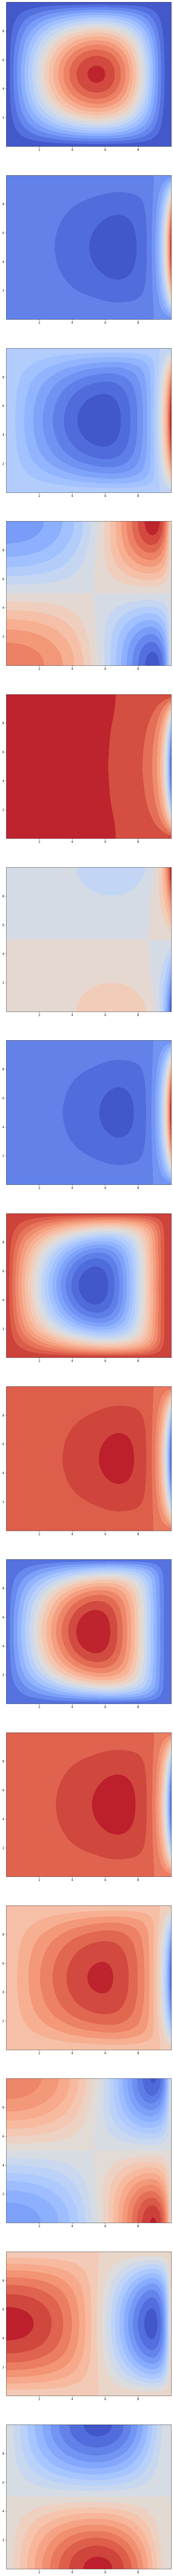

In [9]:
m1 = np.linspace(0.0001,a-0.0001,200)
m2 = np.linspace(0.0001,b-0.0001,200)
x1,y1=np.meshgrid(m1,m2)

fig, axes = plt.subplots(len(dissec), 1, figsize=(10,160))

for j in range(len(dissec)):
    ax = axes[j]
    ax.contourf(x1,y1,-dissec[j](x1,y1),levels=20,cmap='coolwarm')


W ![image.png](attachment:83f91320-a24e-495a-abfd-b3ee513d5001.png )                                              M1 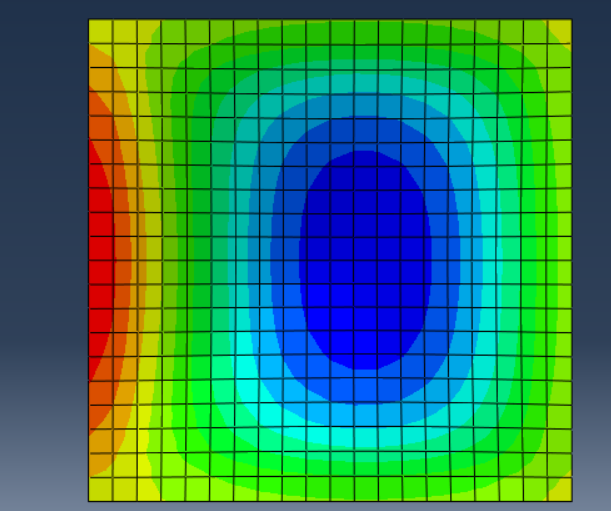         Ey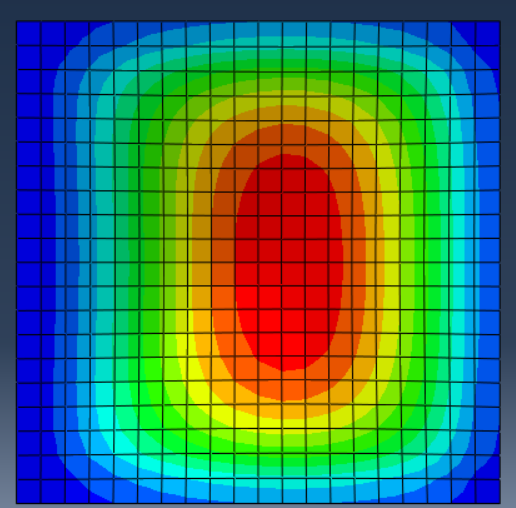       m12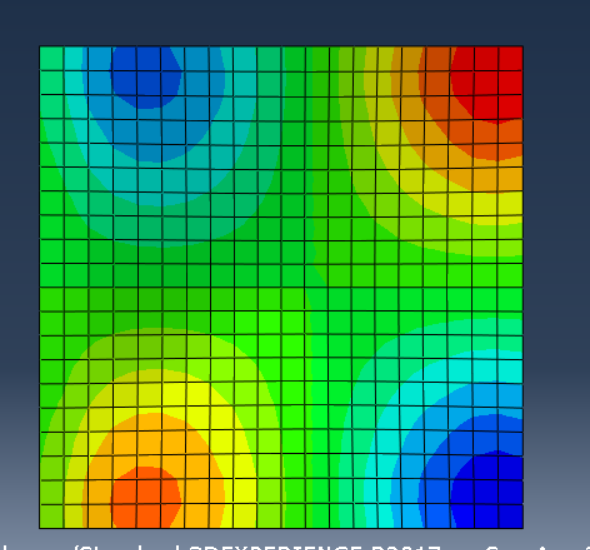

tetax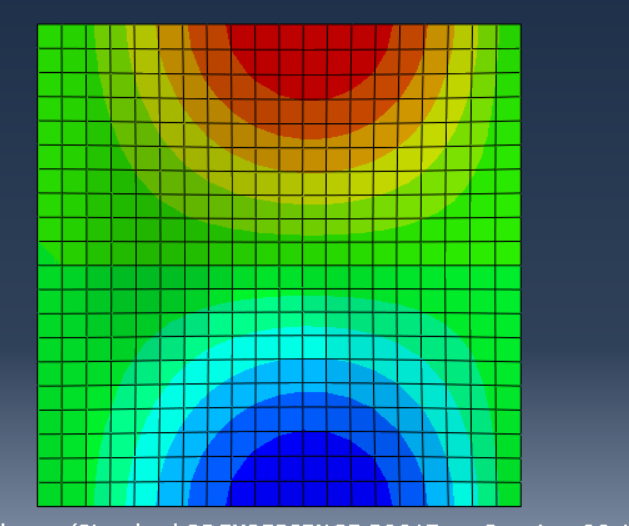                                        teta x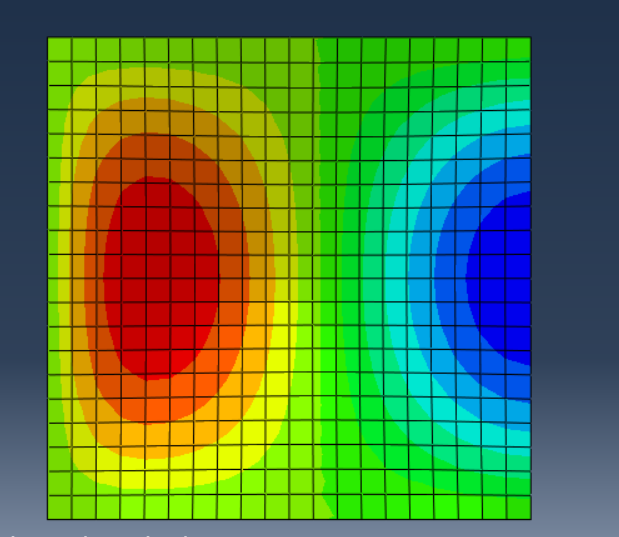
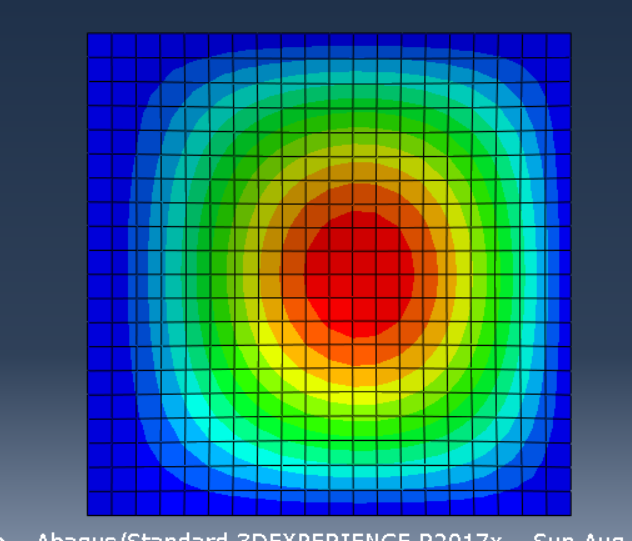

In [10]:
dwdx=(smp.diff(W_simb,x))
Teta0=dwdx.subs([(x,0)])
teta0=smp.lambdify([y],Teta0)

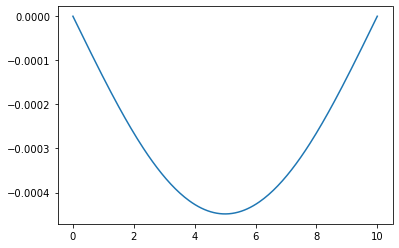

In [11]:
plt.plot(m2,teta0(m2))

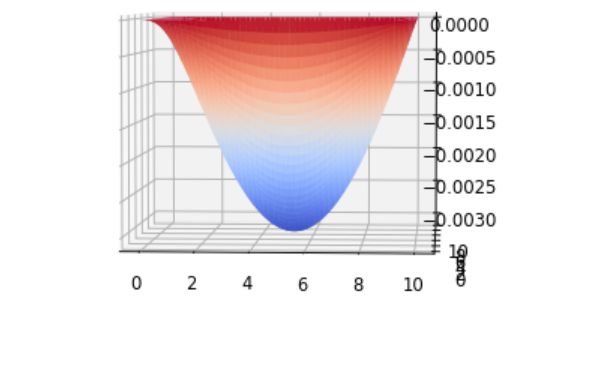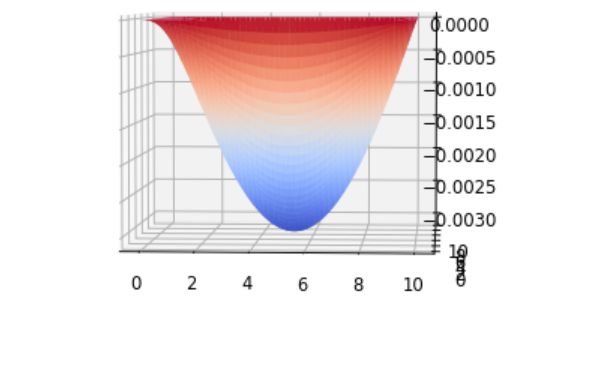